# Example: Gaussian Mixture

- 2020-11-29 first uploaded
- 2021-04-08 backward loss updated

In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import itertools
from flow import *
from utils import *
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.optimizers import Adam,RMSprop
import pandas as pd
import tensorflow as tf
print(tf.__version__)
!python --version

2.8.0
Python 3.9.7


## Settings

In [3]:
dataS = pd.read_csv('MLDataset_quat.csv')
dataS = dataS.drop('Unnamed: 0',axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dataS)
dataS = scaler.transform(dataS)
Y = dataS[:,:7]
#X = np.log(X+np.ones(X.shape))
X = dataS[:,7:]
x_dim = X.shape[1]
y_dim = Y.shape[1]
z_dim = 5
tot_dim = y_dim + z_dim
pad_dim = tot_dim - x_dim
n_data = X.shape[0]
n_couple_layer = 4
n_hid_layer = 2
n_hid_dim = 32

n_batch = 128
n_epoch = 100
n_display = 5

In [4]:
# Pad data
pad_x = np.zeros((X.shape[0], pad_dim))
x_data = np.concatenate([X, pad_x], axis=-1).astype('float32')
print(x_data.shape)
z = np.random.multivariate_normal([0.]*z_dim, np.eye(z_dim), X.shape[0])
y_data = np.concatenate([z, Y], axis=-1).astype('float32')
print(y_data.shape)
# Make dataset generator
x_data = tf.data.Dataset.from_tensor_slices(x_data)
y_data = tf.data.Dataset.from_tensor_slices(y_data)
dataset = (tf.data.Dataset.zip((x_data, y_data))
           .shuffle(buffer_size=X.shape[0])
           .batch(n_batch, drop_remainder=True)
           .repeat())

(60000, 12)
(60000, 12)


## Initialize the model

In [5]:
model = NVP(tot_dim, n_couple_layer, n_hid_layer, n_hid_dim, name='NVP')
x = tfk.Input((tot_dim,))
model(x);
model.summary()

Model: "NVP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer0 (TwoNVPCouplingLayer  multiple                 7588      
 s)                                                              
                                                                 
 Layer1 (TwoNVPCouplingLayer  multiple                 7588      
 s)                                                              
                                                                 
 Layer2 (TwoNVPCouplingLayer  multiple                 7588      
 s)                                                              
                                                                 
 Layer3 (TwoNVPCouplingLayer  multiple                 7588      
 s)                                                              
                                                                 
Total params: 30,352
Trainable params: 30,304
Non-trainable par

In [6]:
class Trainer(tfk.Model):
    def __init__(self, model, x_dim, y_dim, z_dim, tot_dim, 
                 n_couple_layer, n_hid_layer, n_hid_dim, shuffle_type='reverse'):
        super(Trainer, self).__init__()
        self.model = model
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.tot_dim = tot_dim
        self.x_pad_dim = tot_dim - x_dim
        self.y_pad_dim = tot_dim - (y_dim + z_dim)
        self.n_couple_layer = n_couple_layer
        self.n_hid_layer = n_hid_layer
        self.n_hid_dim = n_hid_dim
        self.shuffle_type = shuffle_type

        self.w1 = 5.
        self.w2 = 1.
        self.w3 = 10.
        self.loss_factor = 1.
        self.loss_fit = MSE
        self.loss_latent = MMD_multiscale
        self.loss_backward = MSE

    def train_step(self, data):
        x_data, y_data = data
        x = x_data[:, :self.x_dim]
        y = y_data[:, -self.y_dim:]
        z = y_data[:, :self.z_dim]
        y_short = tf.concat([z, y], axis=-1)

        # Forward loss
        with tf.GradientTape() as tape:
            y_out = self.model(x_data)    
            pred_loss = self.w1 * self.loss_fit(y_data[:,self.z_dim:], y_out[:,self.z_dim:]) # [zeros, y] <=> [zeros, yhat]
            output_block_grad = tf.concat([y_out[:,:self.z_dim], y_out[:, -self.y_dim:]], axis=-1) # take out [z, y] only (not zeros)
            latent_loss = self.w2 * self.loss_latent(y_short, output_block_grad) # [z, y] <=> [zhat, yhat]
            forward_loss = pred_loss + latent_loss
        grads_forward = tape.gradient(forward_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_forward, self.model.trainable_weights))

        # Backward loss
        with tf.GradientTape() as tape:
            x_rev = self.model.inverse(y_data)
            #rev_loss = self.w3 * self.loss_factor * self.loss_fit(x_rev, x_data)
            rev_loss = self.w3 * self.loss_factor * self.loss_backward(x_rev, x_data)
        grads_backward = tape.gradient(rev_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_backward, self.model.trainable_weights)) 

        total_loss = forward_loss + latent_loss + rev_loss
        return {'total_loss': total_loss,
                'forward_loss': forward_loss,
                'latent_loss': latent_loss,
                'rev_loss': rev_loss}

    def test_step(self, data):
        x_data, y_data = data
        return NotImplementedError

In [7]:
trainer = Trainer(model, x_dim, y_dim, z_dim, tot_dim, n_couple_layer, n_hid_layer, n_hid_dim)
opt=RMSprop(learning_rate=0.0001)
optAdam = Adam(amsgrad=True)
trainer.compile(optimizer='RMSprop')

## Train the model

In [8]:
%%time
LossFactor = UpdateLossFactor(n_epoch)
logger = NBatchLogger(n_display, n_epoch)
hist = trainer.fit(dataset,
                   batch_size=n_batch,
                   epochs=n_epoch,
                   steps_per_epoch=n_data//n_batch, 
                   callbacks=[logger, LossFactor], 
                   verbose=0)

=== Started at 2022-03-31 06h:36m:24s ===
 2022-03-31 06h:36m:34s | Epoch: 001/100 | total_loss=0.444102 forward_loss=0.149133 latent_loss=0.095500 rev_loss=0.199469
 2022-03-31 06h:36m:44s | Epoch: 005/100 | total_loss=0.284156 forward_loss=0.086731 latent_loss=0.062031 rev_loss=0.135394
 2022-03-31 06h:36m:54s | Epoch: 010/100 | total_loss=0.238216 forward_loss=0.066338 latent_loss=0.050029 rev_loss=0.121850
 2022-03-31 06h:37m:04s | Epoch: 015/100 | total_loss=0.233324 forward_loss=0.067802 latent_loss=0.050068 rev_loss=0.115453
 2022-03-31 06h:37m:15s | Epoch: 020/100 | total_loss=0.210365 forward_loss=0.060326 latent_loss=0.052209 rev_loss=0.097830
 2022-03-31 06h:37m:27s | Epoch: 025/100 | total_loss=0.236470 forward_loss=0.070490 latent_loss=0.056191 rev_loss=0.109790
 2022-03-31 06h:37m:38s | Epoch: 030/100 | total_loss=0.262271 forward_loss=0.074160 latent_loss=0.057395 rev_loss=0.130716
 2022-03-31 06h:37m:50s | Epoch: 035/100 | total_loss=0.209471 forward_loss=0.059257 laten

In [9]:
pred_result = []
for j in range(100):
    z = np.random.randn(100,z_dim)
    xn = []
    for i in range(z.shape[0]):
        y = np.concatenate([z[[i],:], Y[[j],:]], axis=-1).astype('float32')
        x_pred = model.inverse(y).numpy()
        xn.append(list(x_pred[:,:X.shape[1]]))
    pred_result.append(xn)

In [10]:
z = np.random.randn(100,z_dim)
xn = []
for i in range(z.shape[0]):
    y = np.concatenate([z[[i],:], Y[[-18],:]], axis=-1).astype('float32')
    x_pred = model.inverse(y).numpy()
    xn.append(list(x_pred[:,:X.shape[1]]))

In [11]:
X[-18,:]

array([0.61666667, 0.51666667, 0.48333333, 0.25      ])

In [12]:
from sklearn.metrics import r2_score

In [13]:
val = []
for i in range(len(xn)):
    v = r2_score(X[-18,:],xn[i][0])
    val.append(v)

In [14]:
val.index(max(val))

35

In [15]:
best_result = []
for j in range(len(pred_result)):
    xn = pred_result[j]
    val=[]
    for i in range(len(xn)):
        v = r2_score(X[j,:],xn[i][0])
        val.append(v)
    print(max(val))
    best_result.append(xn[val.index(max(val))])

0.9872047383377135
0.3490814423492009
0.9654674238937951
0.8499559055843247
0.8841064574445486
0.055595529268484656
0.9859494280526775
0.9696456969946173
0.768042121763414
0.4661380156505255
0.32675895947501743
0.9806724041256547
0.07930595319657152
0.3091314147850166
0.9541589914528819
0.8478685274084337
0.7227958438862883
0.8090816254115798
0.32937416024872357
0.13318143432495588
0.3550588280657676
0.9799116524837764
0.5433473142547025
0.9784601659947081
0.9625448125145319
0.6698214121449803
0.9965576495150537
0.9972407007090105
0.9912605631909096
0.09281234035709873
0.8951362212178372
0.9174805727742669
0.9728933336351397
0.9835188381691472
0.7238564915011959
0.3357473945849965
0.43857686599985946
0.5529361257469296
0.8735683219556557
0.9890712549045781
-0.9202504511086138
0.23855890371802846
0.853827639062768
0.17731905831129113
0.6851604771495043
0.9811974475716274
0.9469876367505001
0.4379725084859133
0.9638803225244755
0.9532886809307305
0.6805043851479509
0.8162465551984889
0.9

In [16]:
sa = np.array(best_result).reshape(np.array(best_result).shape[0],np.array(best_result).shape[-1])
r2_score(X[:100,:],sa)

0.7321015873502011

## Check results

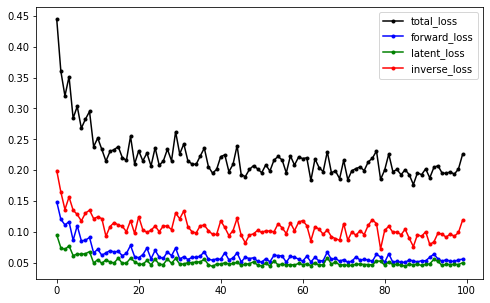

In [17]:
fig, ax = plt.subplots(1, facecolor='white', figsize=(8,5))
ax.plot(hist.history['total_loss'], 'k.-', label='total_loss')
ax.plot(hist.history['forward_loss'], 'b.-', label='forward_loss')
ax.plot(hist.history['latent_loss'], 'g.-', label='latent_loss')
ax.plot(hist.history['rev_loss'], 'r.-', label='inverse_loss')
plt.legend()

In [18]:
Y[[-18],:]

array([[4.68948010e-01, 4.32766691e-01, 8.00423050e-01, 9.88003932e-01,
        5.53191988e-01, 4.72633381e-01, 3.30197978e-17]])

In [24]:
uq_labels = list(set(list(Y[[-18],:])))
idx2lab = {i:lab for i, lab in enumerate(uq_labels)}
lab2idx = {idx2lab[key]:i for i, key in enumerate(idx2lab.keys())}

TypeError: unhashable type: 'numpy.ndarray'

NameError: name 'idx2lab' is not defined

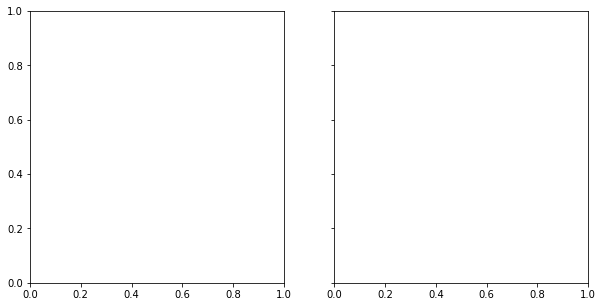

In [21]:
z = np.random.multivariate_normal([1.]*z_dim, np.eye(z_dim), Y[[-18],:].shape[0])
y = np.concatenate([z,Y[[-18],:]], axis=-1).astype('float32')
x_pred = model.inverse(y).numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), facecolor='white', sharex=True, sharey=True)
for i, color in zip(idx2lab.keys(), lab2idx.keys()):
    idx = [True if j==i else False for j in y_onehot.argmax(axis=-1)]
    ax1.scatter(X[idx,0], X[idx,1], s=1, c=color)
    ax2.scatter(x_pred[idx,0], x_pred[idx,1], s=1, c=color)
    ax2.set_xlim([-2, 2])
    ax2.set_ylim([-2, 2])
plt.suptitle('Original (left)                    Prediction (right)', fontsize=20);